In [1]:
import numpy as np 
import pandas as pd 

import sqlite3 as sql 

import matplotlib.pyplot as plt 
import seaborn as sns 
import missingno as msno 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df_match_betting = pd.read_csv("../data/df_match_betting.csv")

In [5]:
df_match_betting

,match_api_id,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,492473,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,492474,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,492475,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,492476,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,492477,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,1992091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25975,1992092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25976,1992093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25977,1992094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Odds are an indication of how likely an outcome is to occur. For very likely outcomes, the odds are lower, meaning the bookmaker is expecting this outcome, and as such, a lower payout is attached to a winning bet.

- Before the last letter means betting site. There are 10 betting sites.
- Last letter
    - "H": Home win odds
    - "D": Draw odds
    - "A": Away win odds
- So there are 10 betting sites * 3 last letter = 30 betting information.

- Let's check the relation between odd and the match result.

In [15]:
con = sql.connect("../data/database.sqlite")
org_match = pd.read_sql(
    "select * from Match", con
    )

In [42]:
match_result_info = org_match[["match_api_id", "home_team_goal", "away_team_goal"]]
match_result_info["match_result"] = match_result_info.home_team_goal - match_result_info.away_team_goal

<AxesSubplot:>

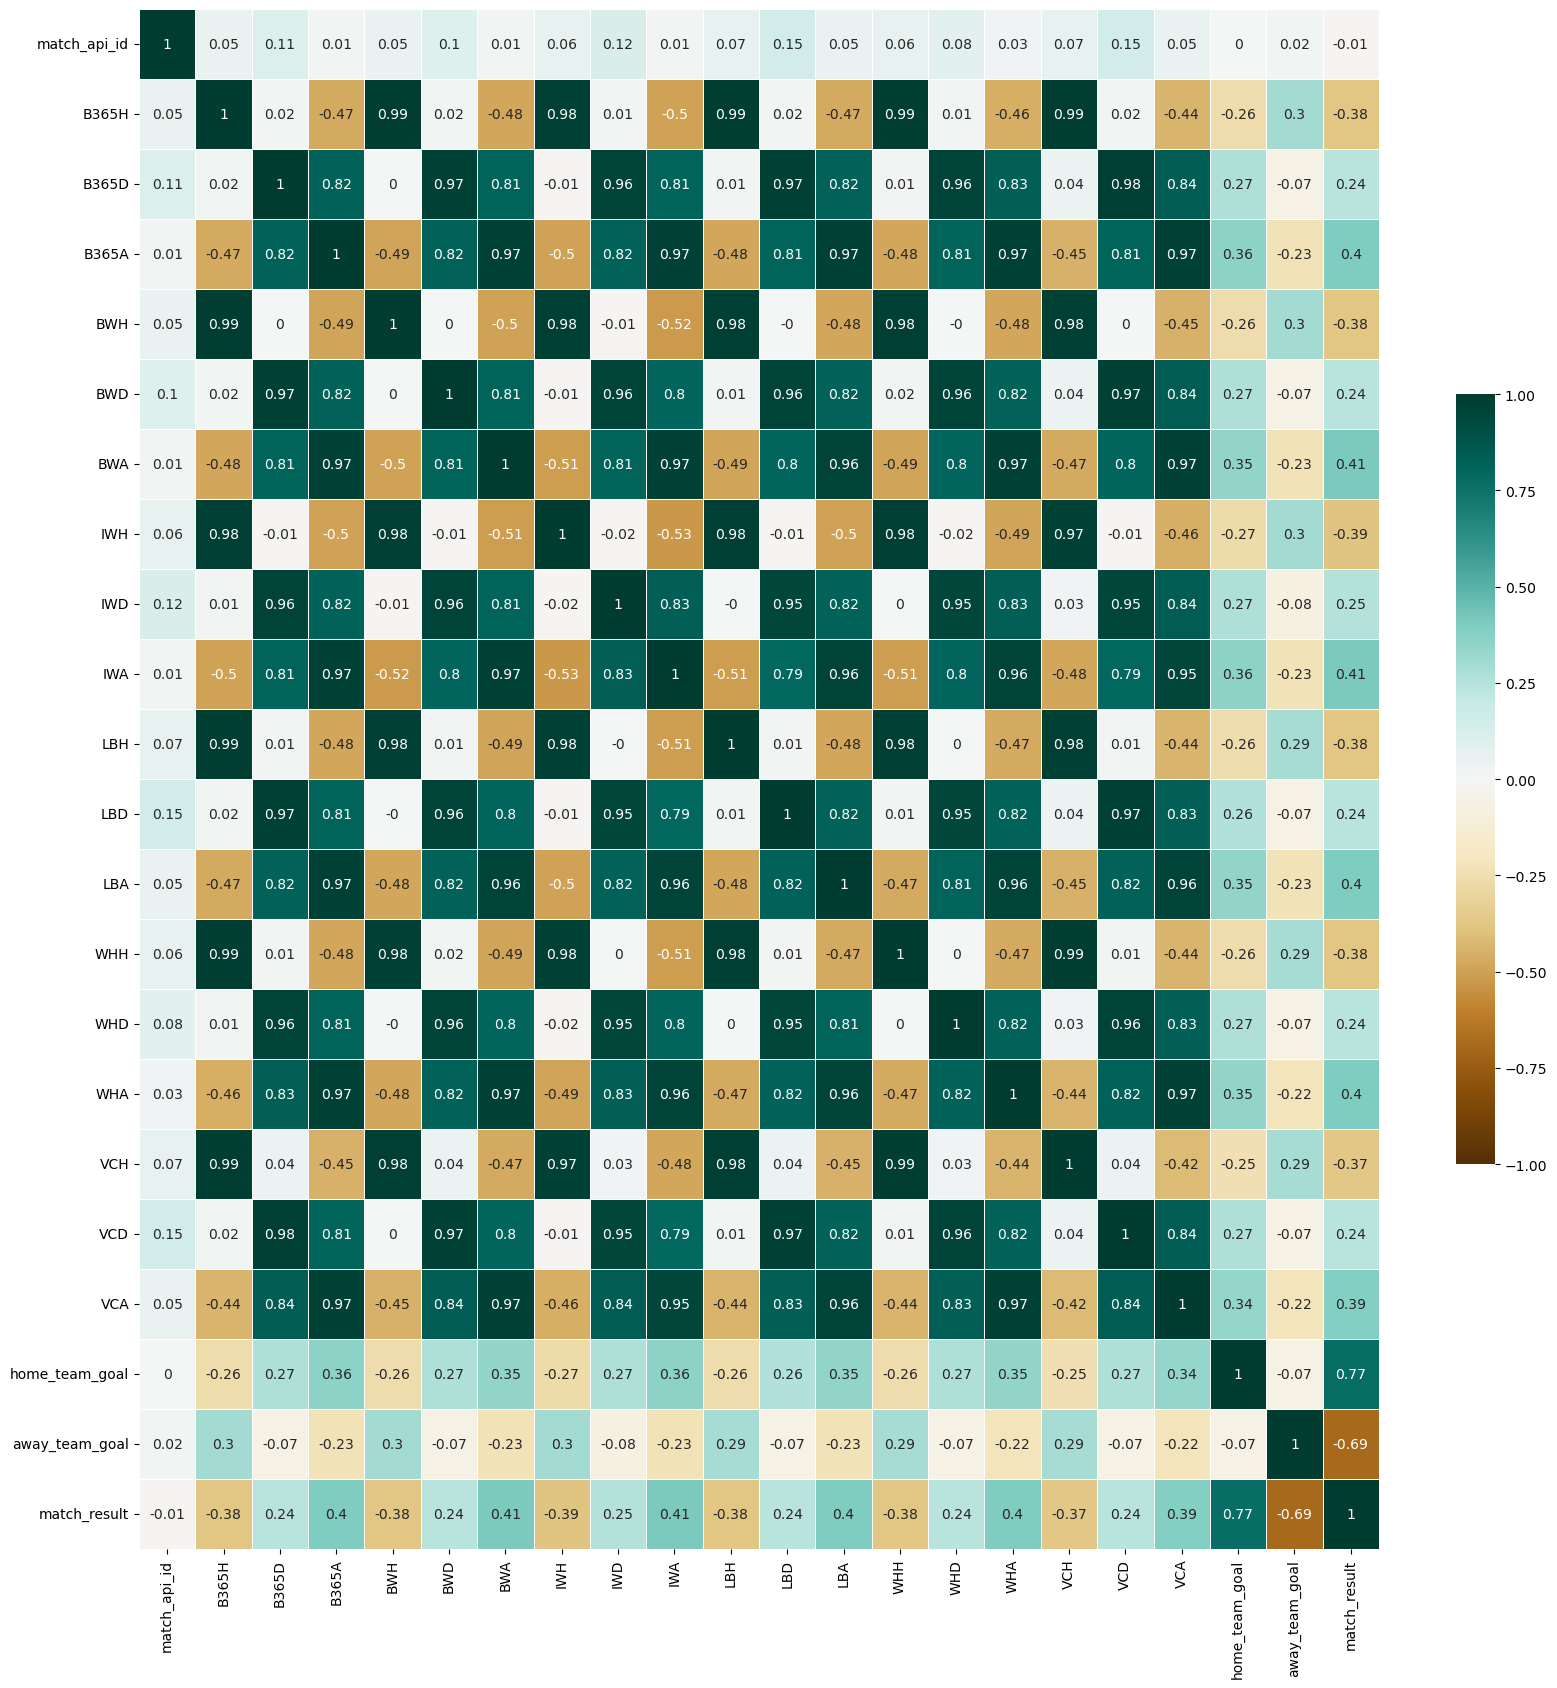

In [43]:
plt.figure(figsize = (20, 20))

corr = round(df_match_betting.merge(match_result_info, how = "left", on = "match_api_id").corr(), 2)

sns.heatmap(corr, annot = True, cmap = "BrBG", vmin = -1, vmax = 1, 
            linewidths = 0.5, cbar_kws = {"shrink" : 0.5})

- Match result (home team goal - away team goal) have some negative correlation with home team win odd.
- Match result have some positive correlation with draw and away win odds.
- That is, it seems that odds have some information related to the match result. So let's use the odd variables as our predictors to predict the match result. 

- Also, 
    - Home team win odd has a correlation close to 1 between different sites.
    - Draw and away team win odd have a correlation close to 1 between different sites.
- That is, there are too many similar information. We need to reduce the betting related variables.

<AxesSubplot:>

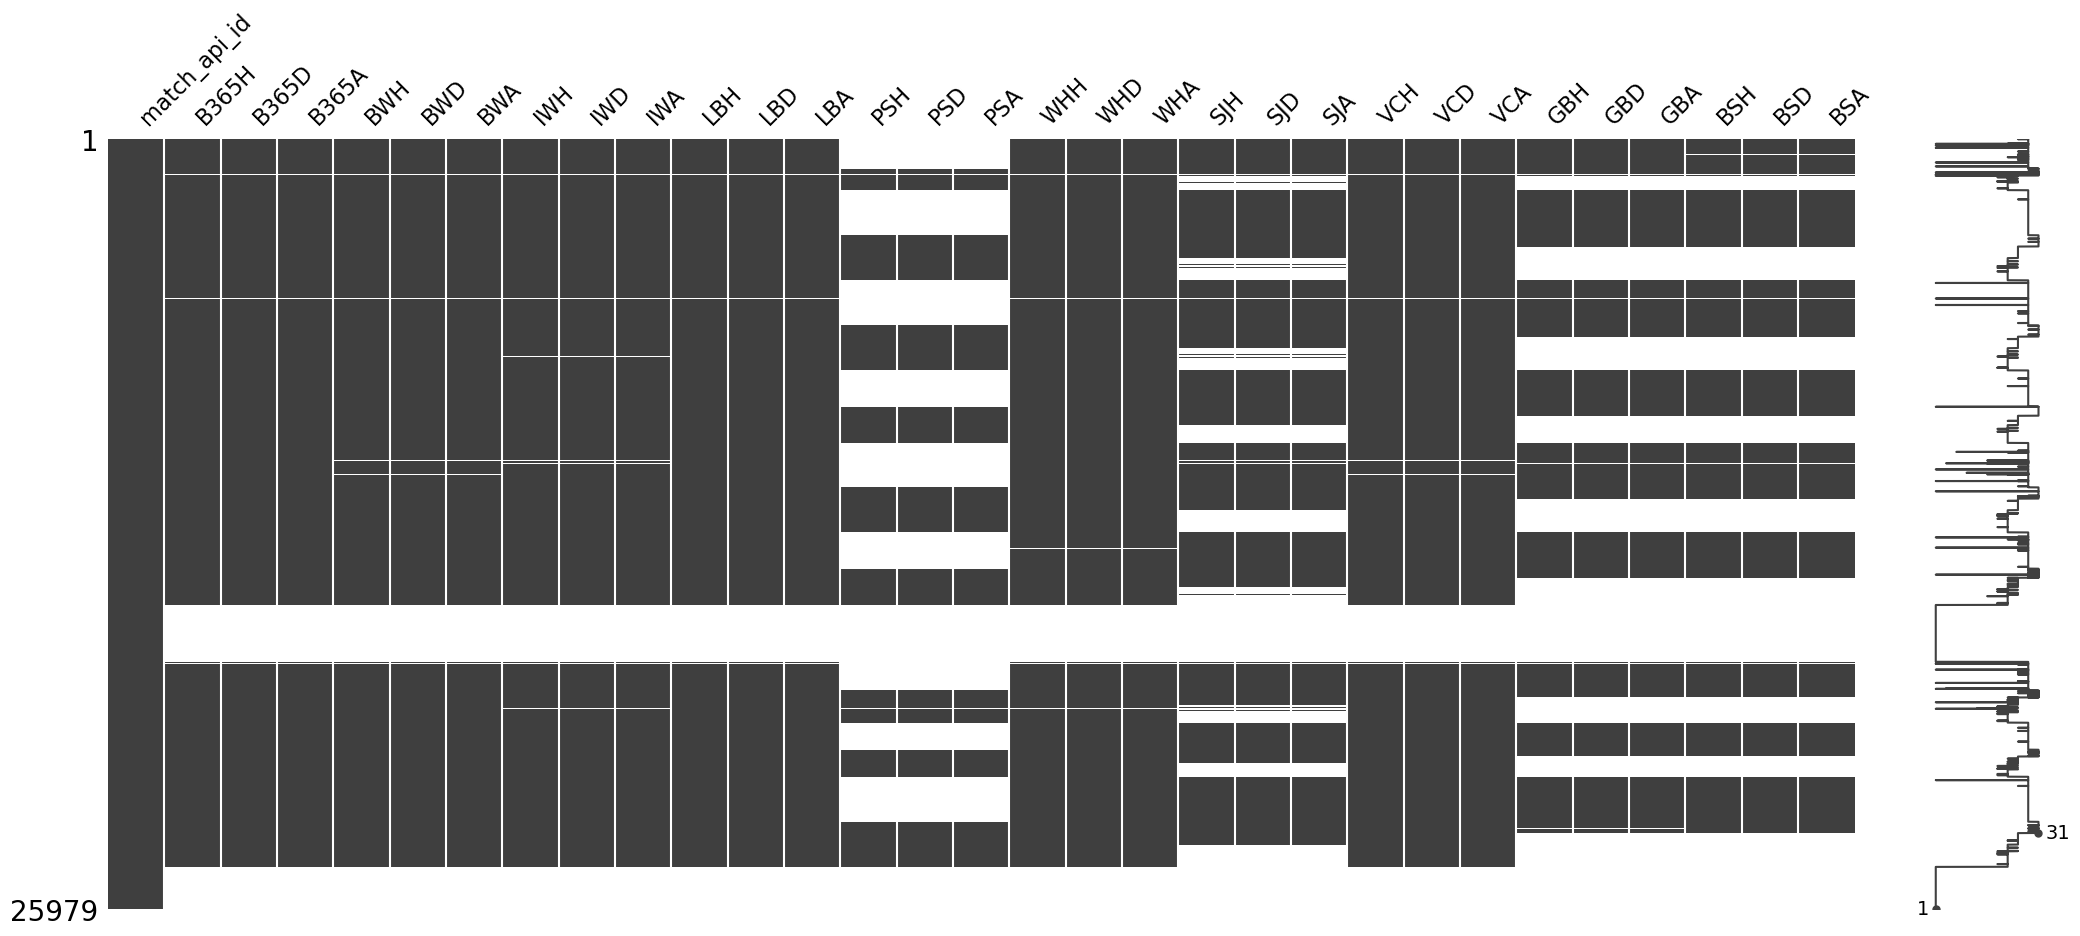

In [8]:
msno.matrix(df_match_betting)

In [10]:
df_match_betting.isna().sum().sort_values(ascending = False)

PSA             14811
PSH             14811
PSD             14811
BSD             11818
BSH             11818
BSA             11818
GBH             11817
GBA             11817
GBD             11817
SJH              8882
SJA              8882
SJD              8882
IWD              3459
IWA              3459
IWH              3459
LBH              3423
LBD              3423
LBA              3423
VCH              3411
VCD              3411
VCA              3411
WHD              3408
WHH              3408
WHA              3408
BWA              3404
BWH              3404
BWD              3404
B365H            3387
B365A            3387
B365D            3387
match_api_id        0
dtype: int64

- First, let's exclude the betting variables with more than 4,000 missing values.

In [11]:
target_cols = df_match_betting.isna().sum()[df_match_betting.isna().sum() > 4000].index.values
df_match_betting = df_match_betting.drop(target_cols, axis = 1)

<AxesSubplot:>

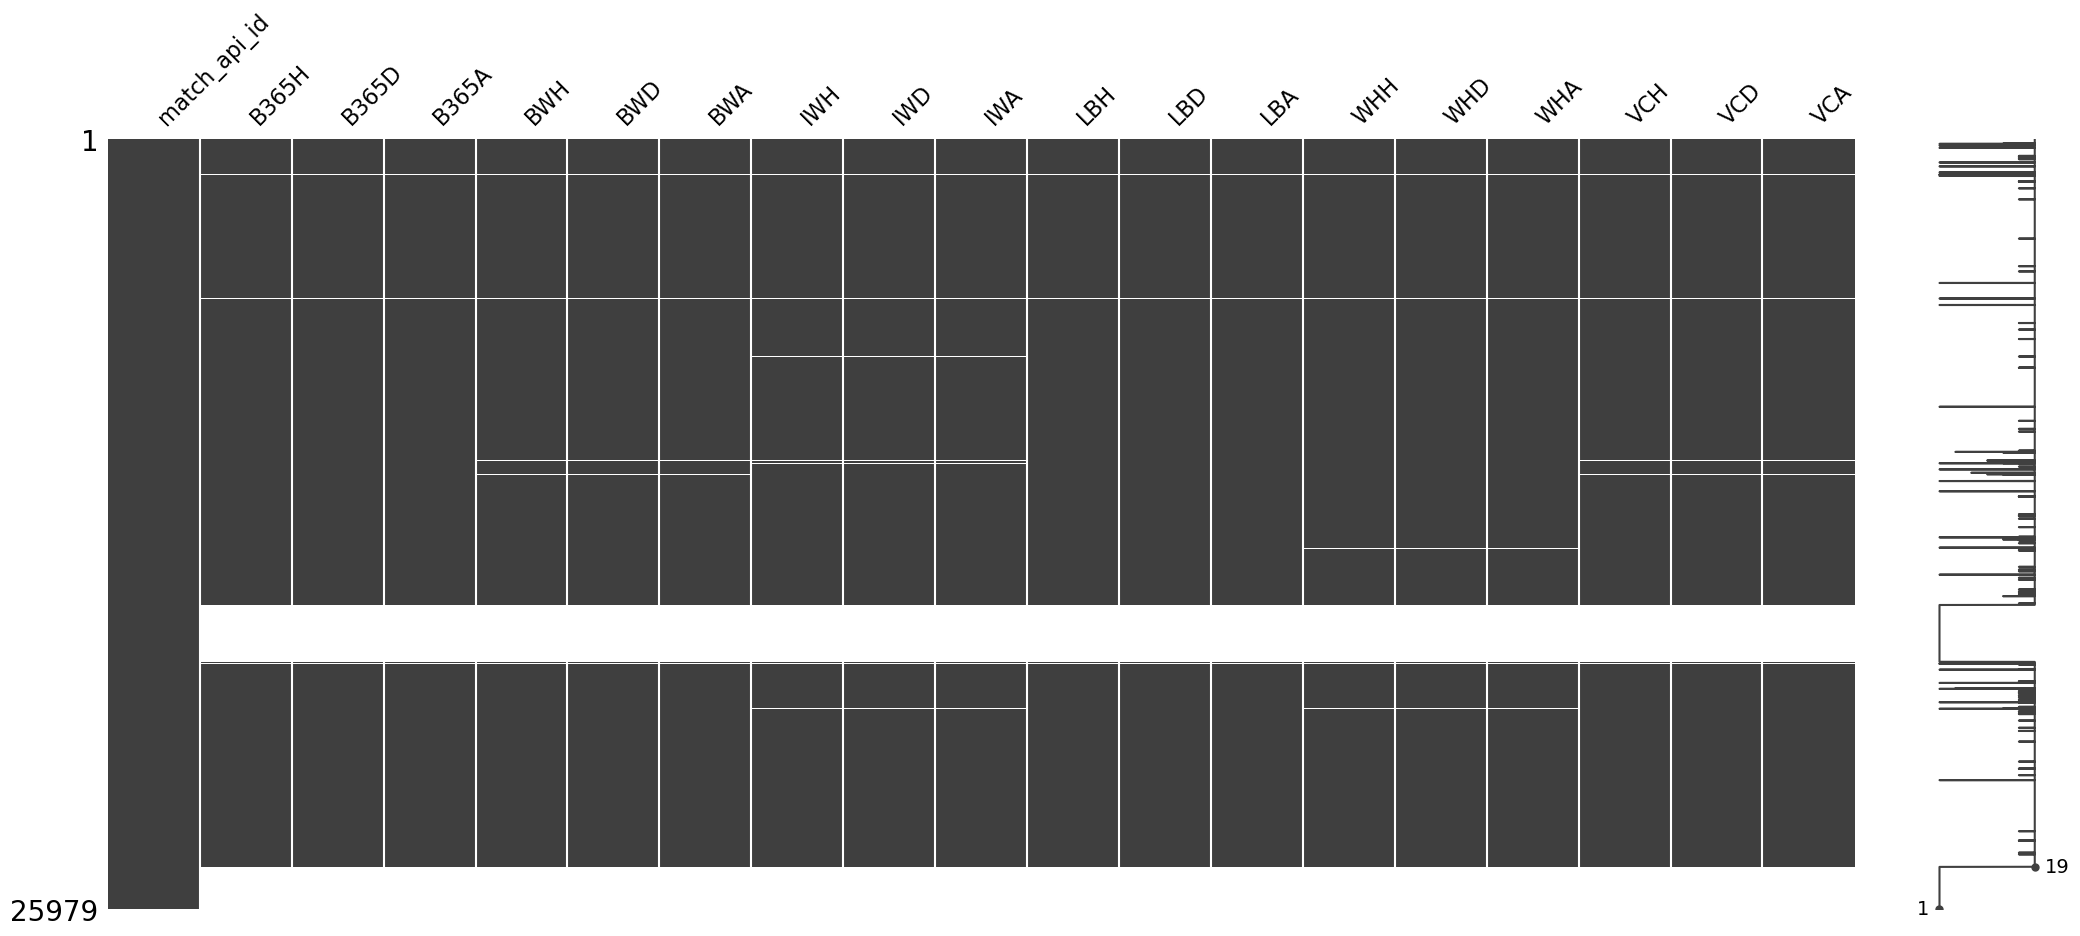

In [13]:
msno.matrix(df_match_betting)

- If there is a mssing value in the B356H, then all betting variables have mssing value.

In [14]:
df_match_betting[df_match_betting.B365H.isna()].shape

(3387, 19)

- There are 3,387 matches that all betting variables have mssing values.
- Simply drop these matches.

In [22]:
df_match_betting = df_match_betting[~df_match_betting.B365H.isna()]

In [25]:
target_id = df_match_betting.match_api_id.unique()

In [24]:
train_match_api_id = pd.read_csv("../data/train_match_api_id.csv")
train_match_api_id.shape

(18343, 1)

In [26]:
train_match_api_id = train_match_api_id[train_match_api_id.match_api_id.isin(target_id)]
train_match_api_id.shape

(17023, 1)

- After drop the matches that don't have any betting information, train matches become 18,343 -> 17,023.

In [27]:
test_match_api_id = pd.read_csv("../data/test_match_api_id.csv")
test_match_api_id.shape

(3018, 1)

In [28]:
test_match_api_id = test_match_api_id[test_match_api_id.match_api_id.isin(target_id)]
test_match_api_id.shape

(2662, 1)

- After drop the matches that don't have any betting information, test matches become 3,018 -> 2,662.

In [29]:
train_match_api_id.to_csv("../data/train_match_api_id.csv", index = False)
test_match_api_id.to_csv("../data/test_match_api_id.csv", index = False)

- If th last letter is
    - "H": Home win odds
    - "D": Draw odds
    - "A": Awa win odds
- That is, if the last letter is same, they have same information between different sites.
- So let's use summary statistics as follow:
    - last letter "H" betting odds: min, max, mean, std 
    - last letter "D" betting odds: min, max, mean, std 
    - last letter "A" betting odds: min, max, mean, std 

In [31]:
H_odds = ["B365H", "BWH", "IWH", "LBH", "WHH", "VCH"]
D_odds = ["B365D", "BWD", "IWD", "LBD", "WHD", "VCD"]
A_odds = ["B365A", "BWA", "IWA", "LBA", "WHA", "VCA"]

In [32]:
H_odds_stat = pd.DataFrame({"H_odd_min": df_match_betting[H_odds].min(axis = 1),
                            "H_odd_max": df_match_betting[H_odds].max(axis = 1),
                            "H_odd_mean": df_match_betting[H_odds].mean(axis = 1),
                            "H_odd_std": df_match_betting[H_odds].min(axis = 1)})

In [33]:
D_odds_stat = pd.DataFrame({"D_odd_min": df_match_betting[D_odds].min(axis = 1),
                            "D_odd_max": df_match_betting[D_odds].max(axis = 1),
                            "D_odd_mean": df_match_betting[D_odds].mean(axis = 1),
                            "D_odd_std": df_match_betting[D_odds].min(axis = 1)})

In [34]:
A_odds_stat = pd.DataFrame({"A_odd_min": df_match_betting[A_odds].min(axis = 1),
                            "A_odd_max": df_match_betting[A_odds].max(axis = 1),
                            "A_odd_mean": df_match_betting[A_odds].mean(axis = 1),
                            "A_odd_std": df_match_betting[A_odds].min(axis = 1)})

In [35]:
df_match_betting_stat = pd.concat([df_match_betting.match_api_id, H_odds_stat, D_odds_stat, A_odds_stat], axis = 1)

In [37]:
df_match_betting_stat

,match_api_id,H_odd_min,H_odd_max,H_odd_mean,H_odd_std,D_odd_min,D_odd_max,D_odd_mean,D_odd_std,A_odd_min,A_odd_max,A_odd_mean,A_odd_std
0,492473,1.65,1.85,1.746667,1.65,3.2,3.4,3.325000,3.2,3.50,5.00,4.213333,3.50
1,492474,1.80,2.00,1.896667,1.80,3.2,3.3,3.241667,3.2,3.25,3.95,3.566667,3.25
2,492475,2.35,2.60,2.455000,2.35,3.1,3.3,3.233333,3.1,2.30,2.75,2.525000,2.30
3,492476,1.40,1.45,1.428333,1.40,3.6,4.0,3.791667,3.6,6.00,7.50,6.550000,6.00
4,492477,4.00,5.00,4.450000,4.00,3.3,3.5,3.416667,3.3,1.60,1.72,1.670000,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24552,2030167,1.57,1.65,1.591667,1.57,3.3,4.0,3.758333,3.3,4.90,7.00,6.400000,4.90
24553,2030168,2.20,2.38,2.288333,2.20,3.1,3.4,3.208333,3.1,3.10,3.40,3.241667,3.10
24554,2030169,1.50,1.60,1.550000,1.50,3.5,4.2,3.900000,3.5,5.40,7.00,6.566667,5.40
24555,2030170,2.30,2.40,2.341667,2.30,3.1,3.4,3.250000,3.1,2.75,3.30,3.083333,2.75


<AxesSubplot:>

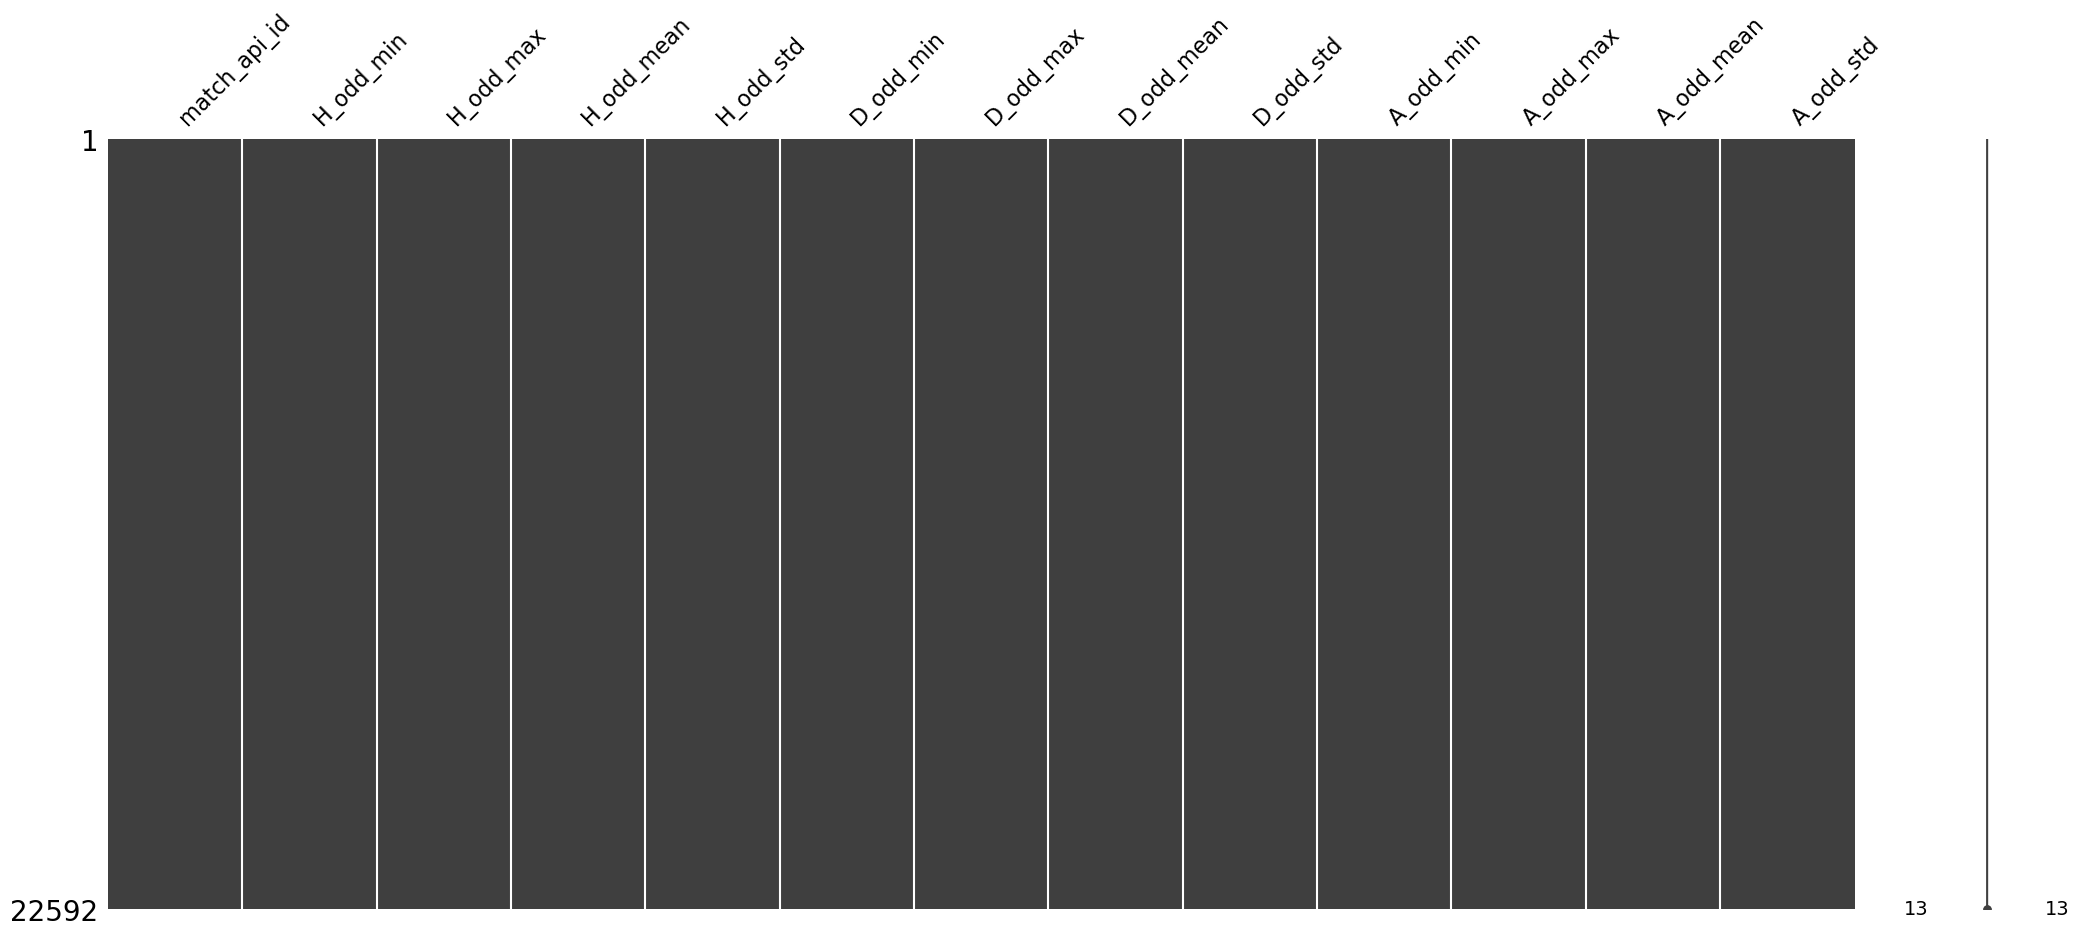

In [39]:
msno.matrix(df_match_betting_stat)

- Finally, we have 3 result (home win, draw, away win) * 4 summary statistics (min, max, mean, std) = 12 betting related variables.

- Save the new data frame.

In [41]:
df_match_betting_stat.to_csv("../data/df_match_betting_stat.csv", index = False)

### <font color="magenta">Summary</font>

- Drop the matches that have the missing values in all betting related columns.
    - train matces: 18,343 -> 17,023
    - test matches: 3,018 -> 2,662

- Drop the betting columns that have more than 4,000 missing values. (drop 12 columns)

- Drop the betting columns that have more than 4,000 missing values. (drop 12 columns)

- If th last letter is
    - "H": Home win odds
    - "D": Draw odds
    - "A": Awa win odds
- That is, if the last letter is same, they have same information between different sites.
- So we made summary statistics as follow:
    - last letter "H" betting odds: min, max, mean, std 
    - last letter "D" betting odds: min, max, mean, std 
    - last letter "A" betting odds: min, max, mean, std 

![2.3.summary](../images/2.3.eda-summary.png)